Time series data using ARIMA models

In [42]:
%pip install sktime seaborn matplotlib pandas statsmodels pmdarima;

In [43]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels

In [44]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1318&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=IPG2211A2N&scale=left&cosd=1939-01-01&coed=2024-03-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-05-07&revision_date=2024-05-07&nd=1939-01-01"

# change for your uploaded URL
df = pd.read_csv(url, parse_dates=['DATE'])
df.columns = ['date', 'production']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(df['date']).drop('date', axis=1)
df.head()

,production
date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


In [45]:
print(df.index.freq)  # This will give you the inferred frequency of the datetime index


None


In [46]:
df = df.resample("MS").last()

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
production,1023.0,56.492136,35.872999,3.3336,20.65055,56.7497,89.33245,126.3772


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='production'>)

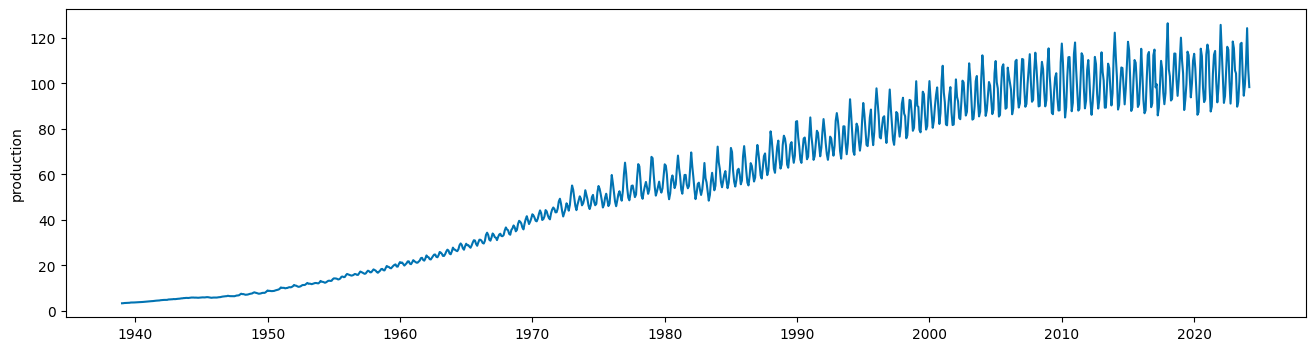

In [48]:
from sktime.utils.plotting import plot_series
plot_series(df, markers=' ')

In [49]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df)
print(adf_result[1])

0.8064038372457225


In [50]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df)
print(kpss_result[1])

0.01


<ipython-input-50-590137705004>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df)


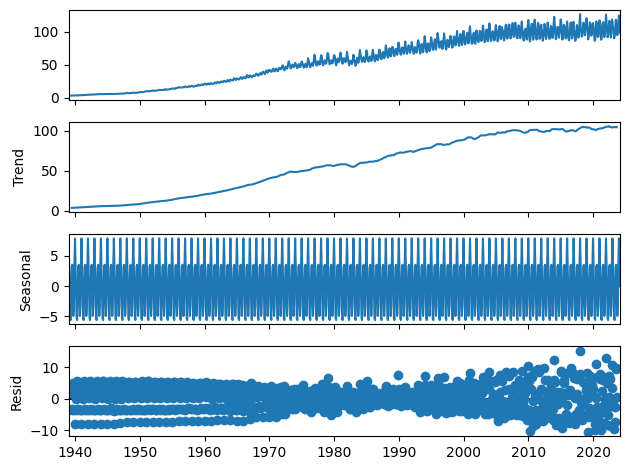

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
result.plot()
pyplot.show()

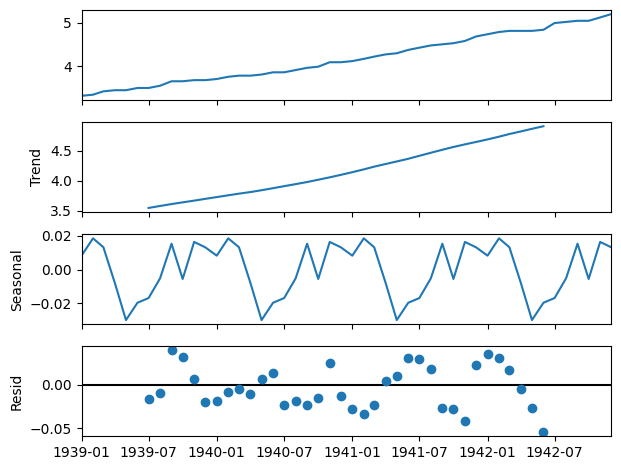

In [52]:
result = seasonal_decompose(df[:48], model='additive')
result.plot()
pyplot.show()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='production'>)

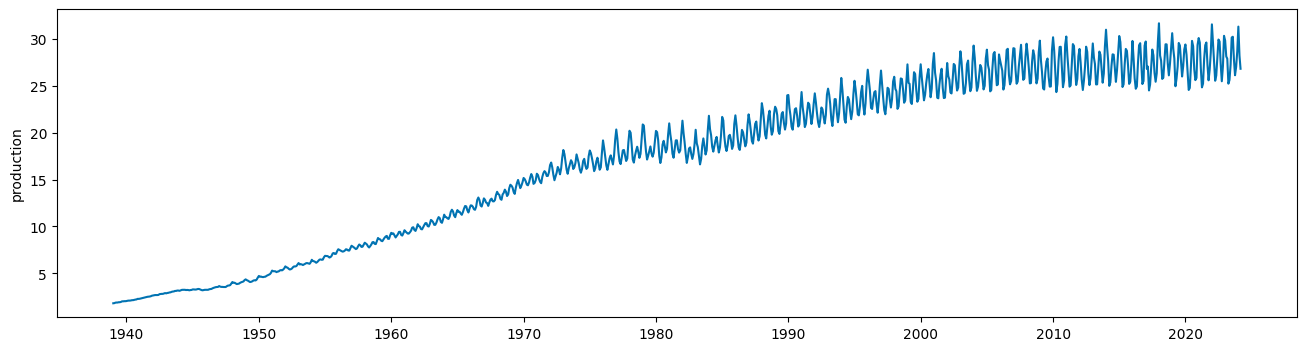

In [53]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

df['production'],fitted_lambda= boxcox(df['production'],lmbda=None)
plot_series(df['production'], markers=' ')

In [54]:
df.head()

,production
1939-01-01,1.799875
1939-02-01,1.816152
1939-03-01,1.864585
1939-04-01,1.880619
1939-05-01,1.880619


In [55]:
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(df, test_size=36)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

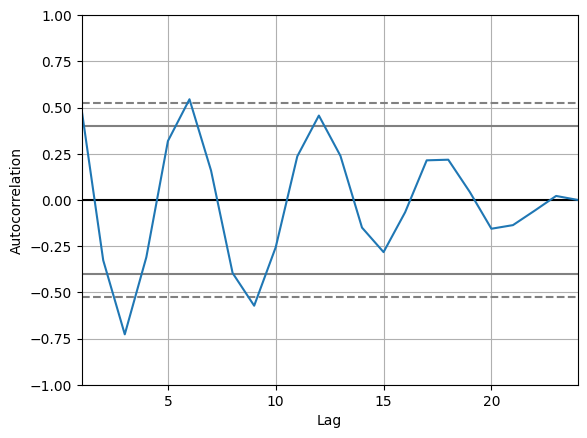

In [56]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train[-24:])

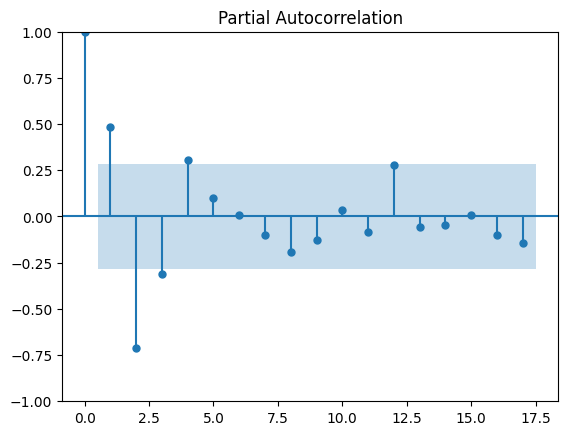

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train[-48:])
pyplot.show()

In [58]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(3,1,0))
model_fit = model.fit()

In [59]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  987
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -899.196
Date:                Thu, 15 Aug 2024   AIC                           1806.391
Time:                        20:14:27   BIC                           1825.966
Sample:                    01-01-1939   HQIC                          1813.836
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2336      0.018     13.347      0.000       0.199       0.268
ar.L2         -0.2893      0.015    -19.329      0.000      -0.319      -0.260
ar.L3         -0.5838      0.016    -36.738      0.0

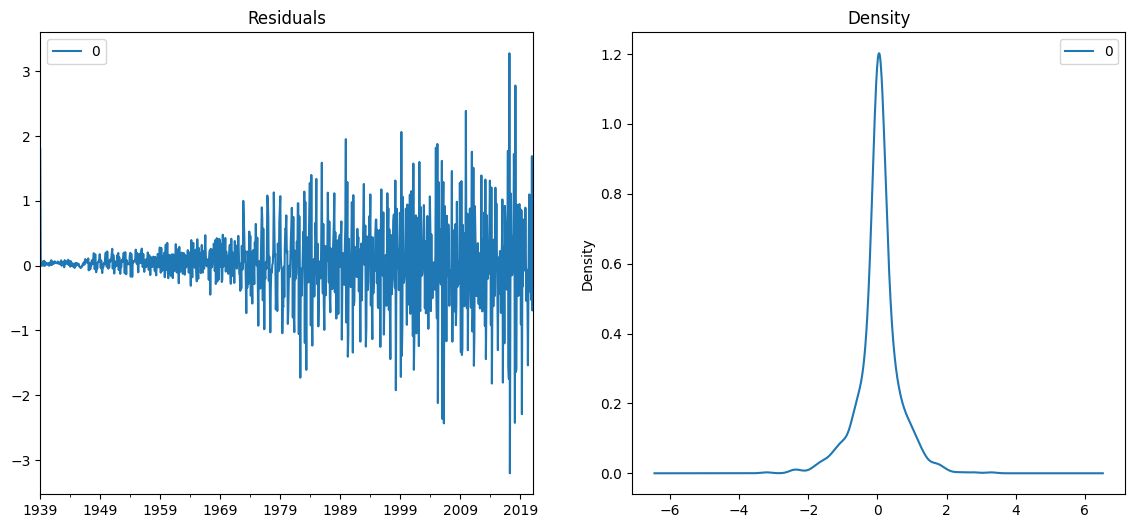

In [60]:
# density plot of residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = pyplot.subplots(1,2, figsize=(14, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
pyplot.show()

In [61]:
history = train
predictions = list()
# walk-forward validation
for t in range(len(test),0,-1):
    model = ARIMA(df[:-t], order=(3,1,0));
    model_fit = model.fit();
    output = model_fit.forecast();
    yhat = output.iloc[0]
    predictions.append(yhat)

<ipython-input-62-f9f5e3bc65cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'predictions'] = predictions.copy()


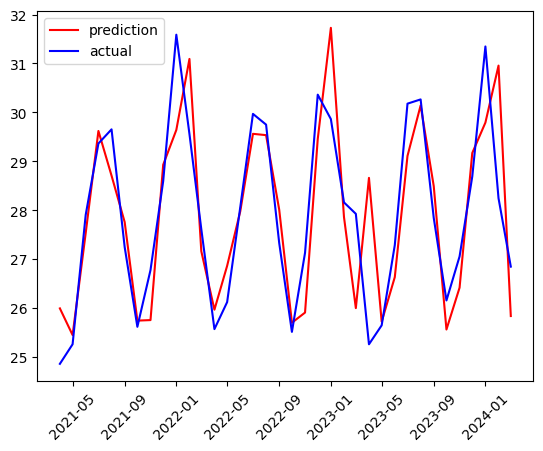

In [62]:
test.loc[:,'predictions'] = predictions.copy()

pyplot.plot(test['predictions'], color='red', label='prediction')
pyplot.plot(test['production'], color='blue', label='actual')
pyplot.legend(loc="upper left")
pyplot.xticks(rotation=45)
pyplot.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(test['predictions'], test['production']))
mae = mean_absolute_error(test['predictions'], test['production'])
print(mae)
print('Test RMSE: %.3f' % rmse)

0.8537160439300313
Test RMSE: 1.138


In [64]:
mean_actual = y_test.mean()

In [65]:
mae_percentage = (mae / mean_actual) * 100
print(f"MAE as a percentage of the mean actual value: {mae_percentage:.2f}%")

MAE as a percentage of the mean actual value: 3.11%


Random Forest for Time Series Forecasting

In [66]:
from sklearn.feature_selection import RFE

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
from pandas import DataFrame
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split

In [69]:
import calendar
import matplotlib.pyplot as plt

In [70]:
# Function to create lagged features
def create_lagged_features(df, lag=1):
    df_lagged = pd.DataFrame()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = df['production'].shift(i)
    df_lagged['production'] = df['production']
    return df_lagged.dropna()

# Create lagged features
lag = 12  # Example: using 12 months of lagged features
df_lagged = create_lagged_features(df, lag=lag)

# Split data into train and test sets
X = df_lagged.drop('production', axis=1)
y = df_lagged['production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [71]:
# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


Train MSE: 0.02222934789077684
Test MSE: 0.9121534421795574


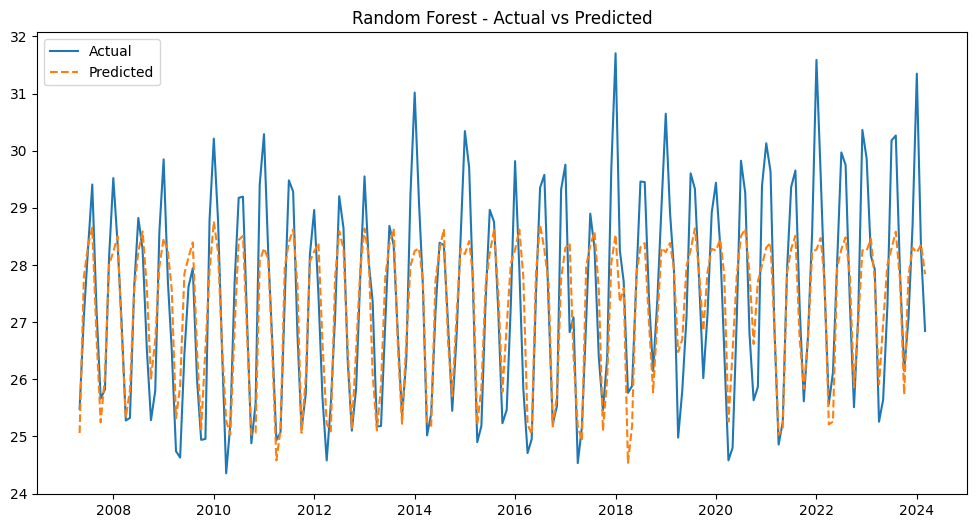

In [72]:
# Calculate and print MSE for train and test sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted', linestyle='--')
plt.title('Random Forest - Actual vs Predicted')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does

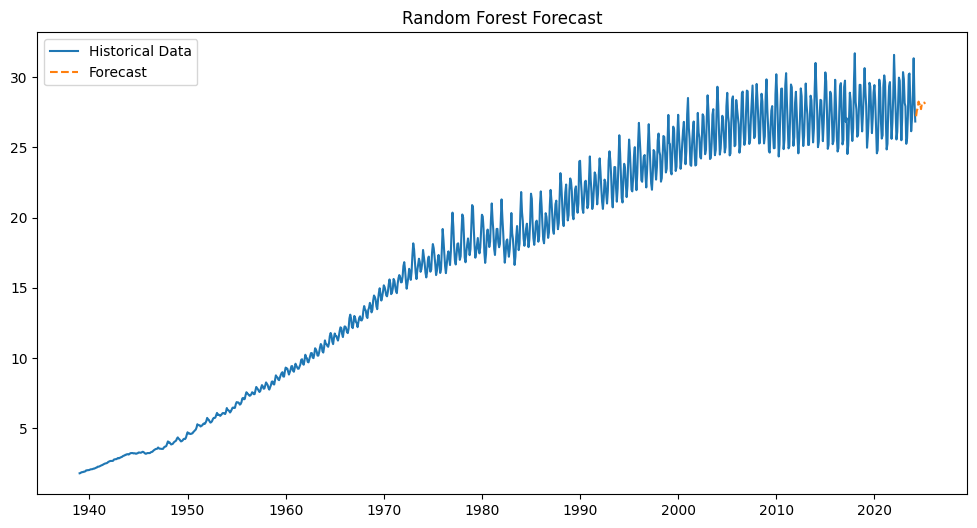

In [73]:
# Forecast future values
def forecast_future(model, df, lag, steps=12):
    last_values = df['production'].values[-lag:]
    future_forecast = []

    for _ in range(steps):
        X_new = last_values[-lag:].reshape(1, -1)
        y_new = model.predict(X_new)
        future_forecast.append(y_new[0])
        last_values = np.append(last_values, y_new)[-lag:]

    return future_forecast

# Forecast the next 12 months (or any desired period)
future_forecast = forecast_future(model, df, lag=lag, steps=12)

# Create a DataFrame for the future forecast
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(1), periods=12, freq='MS')
forecast_df = pd.DataFrame({'production': future_forecast}, index=future_dates)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['production'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['production'], label='Forecast', linestyle='--')
plt.title('Random Forest Forecast')
plt.legend()
plt.show()


In [74]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_test)

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.7258802776430154


In [75]:
mean_actual = y_test.mean()

In [76]:
mae_percentage = (mae / mean_actual) * 100
print(f"MAE as a percentage of the mean actual value: {mae_percentage:.2f}%")

MAE as a percentage of the mean actual value: 2.65%
